In [2]:
import torch
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import os
from torchvision.datasets import ImageFolder
import shutil
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Dog

#### Train dataset curation

##### Load the data and filter the Stanford dataset

In [2]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [3]:
source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filtered_dataset/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [4]:
dataset = ImageFolder('filtered_dataset/train/')

In [5]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [6]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(2506, 278, 1192)

In [7]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [8]:
breeds

['beagle',
 'border_collie',
 'chihuahua',
 'chow',
 'cocker_spaniel',
 'doberman',
 'french_bulldog',
 'giant_schnauzer',
 'golden_retriever',
 'great_dane',
 'labrador_retriever',
 'malinois',
 'maltese_dog',
 'pekinese',
 'pug',
 'rottweiler',
 'saint_bernard',
 'samoyed',
 'tzu',
 'siberian_husky',
 'toy_poodle',
 'west_highland_white_terrier',
 'yorkshire_terrier']

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(2506, 278, 1192)

In [10]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=600x800>, 21)

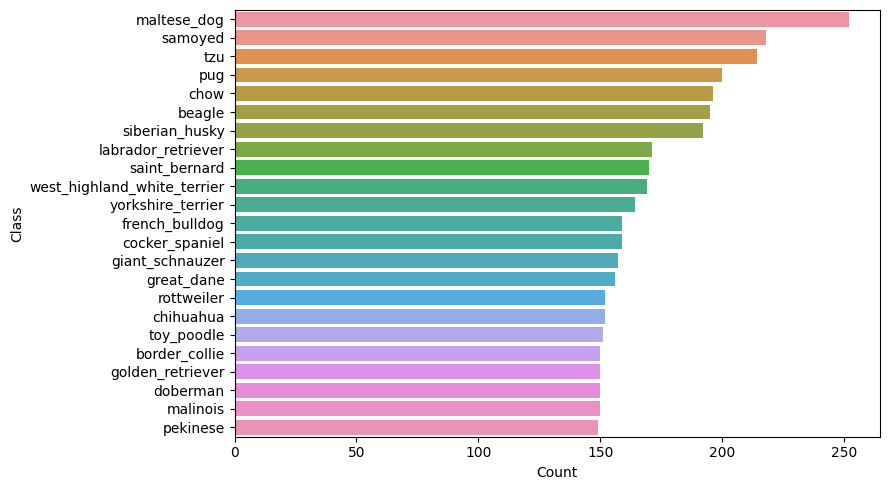

In [11]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

##### DataLoader

In [12]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [13]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
val_dataset = dog_breed.DogBreedDataset(val_ds, val_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

10


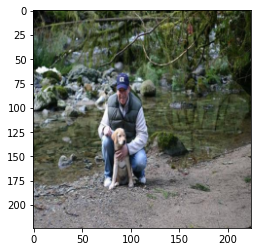

In [37]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

##### Train loop

In [15]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(breeds)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


100%|██████████| 157/157 [00:15<00:00, 10.30it/s]


Train Loss: 1.6539 Acc: 0.6042
Test Loss: 0.7230 Acc: 0.8331
Epoch 2/5


100%|██████████| 157/157 [00:08<00:00, 17.99it/s]


Train Loss: 0.6885 Acc: 0.8372
Test Loss: 0.4575 Acc: 0.8800
Epoch 3/5


100%|██████████| 157/157 [00:08<00:00, 17.83it/s]


Train Loss: 0.4906 Acc: 0.8735
Test Loss: 0.4107 Acc: 0.8826
Epoch 4/5


100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Train Loss: 0.4190 Acc: 0.8803
Test Loss: 0.3746 Acc: 0.8893
Epoch 5/5


100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


Train Loss: 0.3581 Acc: 0.8994
Test Loss: 0.3654 Acc: 0.8800


#### Test on scrapped dataset dog

In [16]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [17]:
source_folder = 'breed_dataset/dog/'
target_folder = 'filtered_dataset/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [18]:
test_data_scrap = ImageFolder('filtered_dataset/test')

In [19]:
all_breeds = test_data_scrap.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [20]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

batch_size = 8
test_dataset_scrap = dog_breed.DogBreedDataset(test_data_scrap, test_transform)
test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

def create_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions)
    return confusion

confusion_matrix_all_classes = create_confusion_matrix(model, test_dl_scrap)



  0%|          | 0/88 [00:00<?, ?it/s]

In [21]:
total_samples = len(test_dataset_scrap)
correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 59.70%


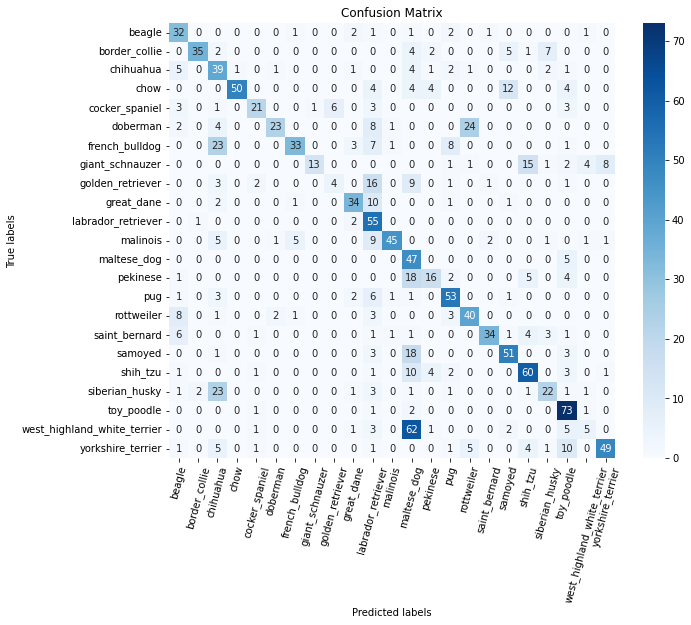

In [22]:
dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, specified_breeds)

### Cat

#### Training

##### Mental illnesses

In [33]:
import os
import shutil

class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

data_dir = 'oxford-iiit-pet/images/images/'

output_dir = 'filter_cat'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            for class_name in class_names:
                if class_name.lower() in file.lower():
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(output_dir, class_name, file)
                    shutil.copy(src_path, dst_path)
                    break 


In [34]:
dataset = ImageFolder('filter_cat/')

In [35]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 10
List of all breeds:
['abyssinian', 'bengal', 'bombay', 'british_shorthair', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


In [36]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(1400, 600)

In [37]:
train_ds_cat, test_ds_cat = random_split(dataset, [train_size, test_size])
len(train_ds_cat), len(test_ds_cat)

(1400, 600)

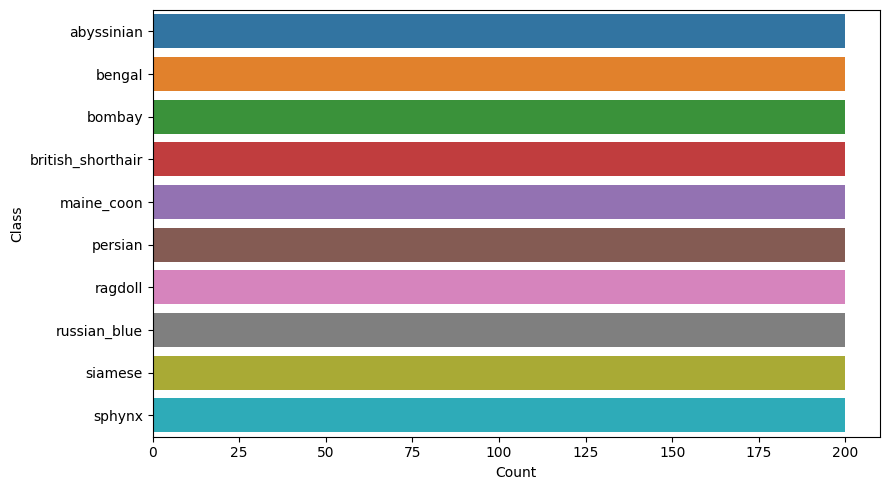

In [38]:
class_names = all_breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

In [39]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [40]:
train_dataset = dog_breed.DogBreedDataset(train_ds_cat, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds_cat, test_transform)

batch_size = 16

train_dl_cat = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl_cat = DataLoader(test_dataset, batch_size*2)

7


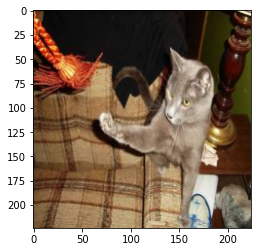

In [41]:
img, label = train_dataset[11]
print(label)
plt.imshow(img.permute(1,2,0))

##### Actual training

In [81]:
import torchvision.models as models


def get_pretrained_model(model_name, num_classes):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
    
    elif model_name == 'vgg19bn':
        model = models.vgg19_bn(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
    
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, num_classes)
    
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    
    elif model_name == 'mobilenetv3':
        model = models.mobilenet_v3_large(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
    
    else:
        raise ValueError("Invalid model name. Please choose from 'resnet18', 'resnet50', 'alexnet', 'vgg19bn', 'inceptionv3', 'densenet', or 'mobilenetv3'")
    
    return model


model_name = "densenet"
num_classes = len(all_breeds)
model = get_pretrained_model(model_name, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train, eval = dog_breed.train_and_test(model, model_name, train_dl_cat, test_dl_cat, criterion, optimizer, device, num_epochs)


Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4406 Acc: 0.5907
Test Loss: 0.7605 Acc: 0.8450
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6631 Acc: 0.8621
Test Loss: 0.4720 Acc: 0.8900
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4715 Acc: 0.8850
Test Loss: 0.3764 Acc: 0.9017
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3578 Acc: 0.9164
Test Loss: 0.3160 Acc: 0.9183
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3296 Acc: 0.9157
Test Loss: 0.2851 Acc: 0.9200
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2694 Acc: 0.9286
Test Loss: 0.2662 Acc: 0.9233
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2650 Acc: 0.9314
Test Loss: 0.2617 Acc: 0.9183
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2326 Acc: 0.9379
Test Loss: 0.2372 Acc: 0.9267
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1916 Acc: 0.9529
Test Loss: 0.2350 Acc: 0.9300
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1999 Acc: 0.9443
Test Loss: 0.2323 Acc: 0.9333
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1936 Acc: 0.9464
Test Loss: 0.2342 Acc: 0.9217
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1769 Acc: 0.9479
Test Loss: 0.2481 Acc: 0.9133
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1689 Acc: 0.9514
Test Loss: 0.2338 Acc: 0.9333
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1459 Acc: 0.9557
Test Loss: 0.2307 Acc: 0.9200
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1550 Acc: 0.9571
Test Loss: 0.2346 Acc: 0.9183


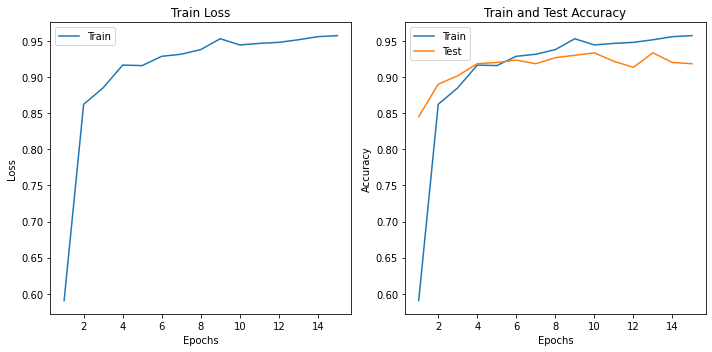

In [82]:
dog_breed.plot_training_history(train, eval)


  0%|          | 0/19 [00:00<?, ?it/s]

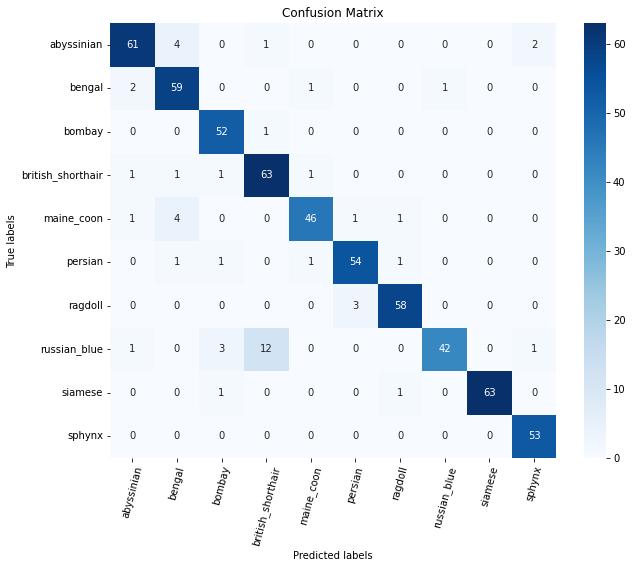

In [83]:
confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_cat)
dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, all_breeds)

#### Test on scrapped dataset cat

In [84]:
test_data_scrap_cat = ImageFolder('breed_dataset/cat/')
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

batch_size = 8
test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)





  0%|          | 0/55 [00:00<?, ?it/s]

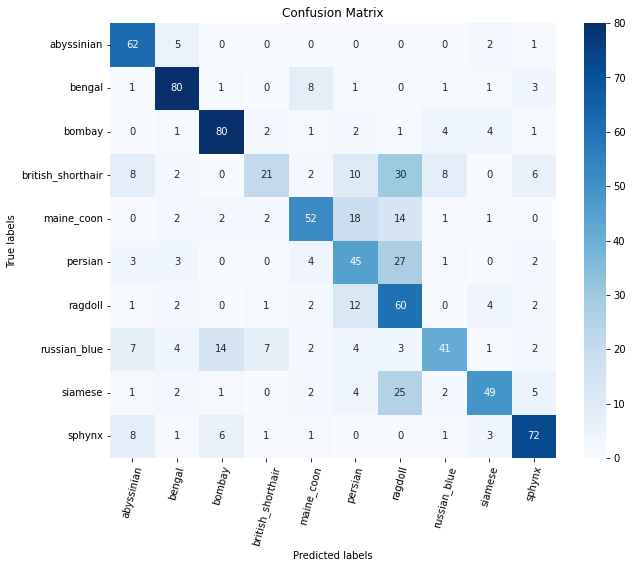

In [77]:
dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, all_breeds)

In [85]:
total_samples = len(test_dataset_scrap)
correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.27%
